In [1]:
import json
import math
import os
from typing import List, Union, Callable

import matplotlib.pyplot as plt
import nglview as nv
import numpy as np
from ase import Atoms
from ase.io import iread
from ipywidgets import IntSlider, interact

from openms.lib.hippynn_es_driver import NNDriver
from openms.lib.misc import A2au, Molecule, fs2au, au2eV, eV2au
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.sh import SH

Could not import 'qutip': No module named 'qutip'


In [13]:
# trajectory taken from /projects/ml4chem/xinyang/azomethane/ml/bomd_s2/7520
xyz = """N  0.4510539073  0.2819140372  -0.3265220727
     N  -0.4422069697  -0.3284274555  0.2246181478
     C  1.8310281758  0.0518381440  0.0321861288
     C  -1.8303581429  -0.0399140770  0.0556092137
     H  2.1618227959  -0.8845481918  -0.4940810058
     H  1.9988787521  0.0074489025  1.1162364759
     H  2.4029900549  0.8707336114  -0.5216418076
     H  -2.0537011535  0.9911549930  -0.4111086677
     H  -2.2848372654  -0.1404426826  1.1142838131
     H  -2.3027538483  -0.8530699287  -0.5390258075"""
veloc = """-1.0051830544     4.7237532296     8.1514131295
    -0.4810829723    -5.8803041478    -4.5214294804
     1.2156820712    -1.0031132209    -3.7910132419
     0.4115438964     4.6371909403    -2.1871828181
    16.4340070438   -26.1365571759    19.2567674439
   -21.7786985133    29.4525856596   -24.1770348763
   -10.8219836994    -5.4896641967     6.6638899192
     4.2697814801   -22.6784903869   -15.7717243249
    22.4895607656   -16.0681027196     0.8823139464
    -9.3191499372    13.4711300432    34.1047197957"""

In [14]:
xyz = """N 0.4760177638  -0.0475940764  -0.4375424021
N -0.4364578671  -0.1642356340  0.4086339167
C 1.8187745667  0.1041611975  0.0581195280
C -1.8498794909  0.0803062997  -0.0363125589
H 1.8315794965  0.4840772946  1.1376072336
H 2.3027755454  0.8024813467  -0.6161179440
H 2.2893537170  -0.8861399303  -0.1261898714
H -1.9947885178  0.8200091191  -0.8472666130
H -2.3527667843  0.4180205764  0.9247652133
H -2.2493589642  -0.8994973379  -0.3282275292"""
veloc = """-0.4674400649    -1.0169339146    -1.2515848404
-4.5802695645    -6.1117892101    -2.3723870239
 0.3804410260     3.1171174706     0.3856583457
-0.8134410199     4.8885310064     2.1782025131
-8.2457995938    19.3517455081    -3.4412219012
12.6343881001    -7.1174829676    -8.2430458898
16.4085815154    -0.7456967398    13.9815710165
29.9130482951    -7.7238001396    30.2826658291
13.1669746917    15.5454290290    -0.4174714459
12.0268386979   -15.6140137393   -12.1960564813"""

In [15]:
xyz = """N 0.4386246590  0.4683425667  0.0162102542
N -0.4221371534  -0.3741148589  0.0334353020
C 1.8071876194  -0.0134679646  -0.0555483545
C -1.8229634658  -0.0671037601  0.0294365741
H 2.2163206213  0.3080685749  -1.0428156227
H 1.9986510434  -1.1077822167  -0.0013631308
H 2.4218028130  0.4418589773  0.7716328522
H -2.3718679194  0.7975953032  0.6130287749
H -2.3102838613  -0.9883462981  0.4165837910
H -2.1078510853  0.0571924957  -1.0651753124"""
veloc = """-3.9944678796    -1.2327700072     0.3087792070
 1.1959405972    -5.8317550647    -0.6388541191
-1.2058315431     2.6239861314    -5.1007340476
-0.9262821777     1.3128022546    -0.9050969346
40.3385125202     0.5430705388    33.3021658873
 4.6789793516    -5.1703155049    22.3892864385
 3.1370711637    12.2096434266   -10.1738880937
-0.9531474432     0.2603804291     7.2878251901
-0.7386936488    21.9605921451     4.2938202112
18.3450676015    21.8646663433    19.6601855878"""

In [16]:
veloc = np.array(veloc.split(), dtype=float).reshape(-1, 3) * A2au / fs2au / 1000

In [17]:
def build_molecules(xyz: Union[str, List[str]], sample_veloc=False, sigma=None, **kwargs):
    if isinstance(xyz, str):
        test_molecules = Molecule(atom=xyz, **kwargs)
        # generate random velocities
        if sample_veloc:
            v = np.random.randn(*test_molecules.veloc.shape) * sigma
            test_molecules.veloc = v
    else:
        test_molecules = []
        for _ in xyz:
            mol = Molecule(atom=_, **kwargs)
            if sample_veloc:
                v = np.random.randn(*mol.veloc.shape) * sigma
                mol.veloc = v
            test_molecules.append(mol)
    return test_molecules

In [18]:
from scipy.integrate import RK45


def scipy_integrator(f: callable, t0: float, y: float, dt: float):
    scipy_rk4 = RK45(f, t0, y, t0 + dt, max_step=dt)
    count = 0
    while scipy_rk4.status == "running":
        scipy_rk4.step()
        count += 1
    print(f"{count} iterations")
    return scipy_rk4.y

In [19]:
# TODO: convert this to a class
def rk45(func: Callable, t0: float, y0: Union[float, np.array], dt: float, tol=1e-4, max_iter=50):
    """Dormand–Prince (a Runge-Kutta 45) integrator for an arbitrary univariate
    function. The coefficients are taken from the original paper
    https://www.sciencedirect.com/science/article/pii/0771050X80900133

    :param func: derivate of the function needs to be integrated. dy/dt
    :type func: Callable
    :param t0: initial time of current step
    :type t0: float
    :param y0: value of the function y at current step
    :type y0: Union[float, numpy.array]
    :param dt: time step
    :type dt: float
    :return: value of function y at t0 + dt
    :rtype: Union[float, numpy.array]
    """
    t = t0
    t_end = t0 + dt
    count = 0
    while t < t_end and count < max_iter:
        if t + dt > t_end:
            dt = t_end - t
        y0, t, dt = rk45_one_step(func, t, y0, dt, tol)
        count += 1
        print(dt, t)

    if count >= max_iter:
        print(f"maximum number of iteration {max_iter} reached")
        y0, _, _ = rk45_one_step(func, t, y0, t_end - t, tol, check_error=False)
        
    print("Done RK4")
    return y0

def rk45_one_step(func: Callable, t0: float, y0: Union[float, np.array], dt: float, tol, check_error=True):
    k1 = dt * func(t0, y0)
    k2 = dt * func(t0 + 1 / 5 * dt, y0 + 1 / 5 * k1)
    k3 = dt * func(t0 + 3 / 10 * dt, y0 + 3 / 40 * k1 + 9 / 40 * k2)
    k4 = dt * func(t0 + 4 / 5 * dt, y0 + 44 / 45 * k1 - 56 / 15 * k2 + 32 / 9 * k3)
    k5 = dt * func(
        t0 + 8 / 9 * dt,
        y0
        + 19372 / 6561 * k1
        - 25360 / 2187 * k2
        + 64448 / 6561 * k3
        - 212 / 729 * k4,
    )
    k6 = dt * func(
        t0 + dt,
        y0
        + 9017 / 3168 * k1
        - 355 / 33 * k2
        + 46732 / 5247 * k3
        + 49 / 176 * k4
        - 5103 / 18656 * k5,
    )
    k7 = dt * func(
        t0 + dt,
        y0
        + 35 / 384 * k1
        + 500 / 1113 * k3
        + 125 / 192 * k4
        - 2187 / 6784 * k5
        + 11 / 84 * k6,
    )
    y_next = (
        y0
        + 35 / 384 * k1
        + 500 / 1113 * k3
        + 125 / 192 * k4
        - 2187 / 6784 * k5
        + 11 / 84 * k6
    )
    y_error = (
        (35 / 384 - 5179 / 57600) * k1
        + (500 / 1113 - 7571 / 16695) * k3
        + (125 / 192 - 393 / 640) * k4
        + (-2187 / 6784 + 92097 / 339200) * k5
        + (11 / 84 - 187 / 2100) * k6
        + (-1 / 40) * k7
    )

    if check_error:
        # error_norm = np.linalg.norm(y_error / (np.maximum(np.abs(y0), np.abs(y_next)) + tol)) * dt 
        error_norm = np.linalg.norm(y_error) / np.linalg.norm(y_next) * dt 
        if error_norm <= tol:
            t0 = t0 + dt
            y0 = y_next
        dt *= min(max(0.2, 0.8 * (tol / error_norm) ** (1 / 5)), 5.0)
    else:
        t0 = t0 + dt
        y0 = y_next

    return y0, t0, dt

In [20]:
"""
basic MQC module
"""

import datetime
import math
import os
import shutil
import textwrap
from copy import copy
from typing import List, Union

import numpy as np
import torch

# This should be equivalent to the APC subroutine in NEXMD
# TODO: implement one version ourselves?
from scipy.optimize import linear_sum_assignment

import openms
from openms.lib.misc import Molecule, au2A, call_name, fs2au, typewriter
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.propagator import rk4

from openms.qmd.mqc import MQC


# TODO: this kind of definition should be part of backend
ArrayLike = Union[np.ndarray, torch.Tensor]

"""
basic MQC module
"""

import datetime
import math
import os
import shutil
import textwrap
from copy import copy
from typing import List, Union

import numpy as np
import torch

# This should be equivalent to the APC subroutine in NEXMD
# TODO: implement one version ourselves?
from scipy.optimize import linear_sum_assignment

import openms
from openms.lib.misc import Molecule, au2A, call_name, fs2au, typewriter
from openms.qmd.es_driver import QuantumDriver
from openms.qmd.mqc import MQC
from openms.qmd.propagator import rk45

# TODO: this kind of definition should be part of backend
ArrayLike = Union[np.ndarray, torch.Tensor]


class SH(MQC):
    """Class for nuclear/electronic propagator used in surface hopping dynamics

    Attributes:
       :param object molecule: Molecule object

    """

    def __init__(
        self,
        molecule: List[Molecule],
        init_states: int,
        init_coef: np.array,
        qm: QuantumDriver,
        algorithm="FS",
        thermostat=None,
        decoherence=True,
        frustrated_hop=True,
        first_state=1,
        **kwargs,
    ):
        """Surface hopping

        :param molecule: list of molecular objects
        :type molecule: List[Molecule]
        :param init_states: initial states of each molecule
        :type init_states: np.array
        :param init_coef: initial wavefunction coefficients of each molecule
        :type init_coef: np.array
        :param qm: electronic structure driver
        :type qm: QuantumDriver
        :param thermostat: thermostat, defaults to None
        :type thermostat: object, optional
        """
        # Initialize input values
        super().__init__(molecule, init_states, init_coef, qm, thermostat, **kwargs)
        self.__dict__.update(kwargs)
        self.md_type = self.__class__.__name__
        # self.curr_ham = np.empty((len(self.mol), self.nstates, self.nstates))
        # a quick and dirty way to find the number of states
        if len(init_coef) > 30:
            self.find_hop = self._find_hop_numpy
        else:
            self.find_hop = self._find_hop_loop
        self.decoherence = decoherence
        self.frustrated_hop = frustrated_hop
        self.first_state = first_state
        self.curr_coords = np.array([])
        self.curr_veloc = np.array([])
        self.sync_variables("coords")
        self.sync_variables("veloc")
        self.curr_ham = np.empty(
            (self.nstates - self.first_state, self.nstates - self.first_state),
            dtype=complex,
        )
        if algorithm == "FS":
            self.electronic_propagator = self._electronic_propagator_fs
            self.velocity_rescaling = self._velocity_rescaling_fs
            self.hopping_probability = self._hopping_probability_fs
        elif algorithm == "LZ":
            self.electronic_propagator = self._electronic_propagator_lz
            self.velocity_rescaling = self._velocity_rescaling_lz
            self.hopping_probability = self._hopping_probability_lz
        else:
            raise ValueError("Unknown algorithm for hopping probability")
        self.curr_time: float
        self.saved_coords: ArrayLike
        self.probability: ArrayLike

    def initialize(self, *args):
        r"""Prepare the initial conditions for both quantum and classical EOM
        It should be implemented in derived class!
        """
        # call the BaseMD.initialize for the nuclear part.
        base_dir, md_dir, qm_log_dir = super().initialize(*args)

        # initialization for electronic part (TBD)
        return base_dir, md_dir, qm_log_dir
        # return NotImplementedError("Method not implemented!")

    def sync_variables(self, var_name, forward=True):
        current = f"curr_{var_name}"
        # from self.mol[:].var_name to self.curr_{var_name}
        if forward:
            tmp = np.array([getattr(mol, var_name) for mol in self.mol])
            if hasattr(getattr(self, current), "__trunc__"):
                setattr(self, current, tmp[0])
            else:
                setattr(self, current, tmp)
        else:
            tmp = getattr(self, current)
            if hasattr(tmp, "__trunc__"):
                [setattr(mol, var_name, tmp) for mol in self.mol]
            else:
                [setattr(mol, var_name, v) for mol, v in zip(self.mol, tmp)]

    def _electronic_propagator_fs(self):
        coef = copy(self.coef)
        p = np.zeros(len(coef))
        # self.sync_variables("coords")
        self.sync_variables("veloc")
        for _ in range(self.nesteps):
            coef = self.quantum_step(self.curr_time, coef)
            # print("coefficients", coef)
            density = self.get_densities(coef)
            p = self.hopping_probability(p, density)
            self.curr_time += self.edt
            self.curr_coords = self.saved_coords
        self.sync_variables("coords", forward=False)
        # print("sh", self.curr_coords)
        # e = self.qm.get_energies(self.mol[0].coords)
        # nacr = self.qm.get_nacr()
        # self.check_hops(coef, p, e, nacr)
        self.coef = coef
        self.probability = p
        # assign updated coefficients to each molecule
        # FIXME: this will only work if there is one molecule
        # for i, m in enumerate(self.mol):
        #     m.coef = coef[i]

    # the name of this function is for symmetry only
    def _electronic_propagator_lz(self):
        self.sync_variables("veloc")
        p = np.zeros(len(self.coef))
        for _ in range(self.nesteps):
            p = self.hopping_probability(p, None)
        self.sync_variables("coords")
        self.probability = p

    def quantum_step(self, t: float, coef: np.array):
        """Propagate one quantum step

        :param t: current time t
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: coefficient at time t + quantum_step
        :rtype: np.array
        """
        return rk45(self.get_coef_dot, t, coef, self.edt)
        # return scipy_integrator(self.get_coef_dot, t, coef, self.edt)

    def get_coef_dot(self, t: float, coef: np.array):
        """Calculate the acceleration for the coefficient at given Hamiltonian

        :param t: current time
        :type t: float
        :param coef: coefficients at current time
        :type coef: np.array
        :return: time derivative of the coefficients at current time
        :rtype: np.array
        """
        # if saved time is different from given current time
        # the Hamiltonian needs to be recalculated
        # if t != self.curr_time:
        # FIXME: in many molecule case, this will not work.
        # self.curr_coords += self.curr_veloc * self.edt / 2
        # energies = self.qm.get_energies(self.curr_coords)
        # nact = self.qm.get_nact(self.curr_coords)
        # self.curr_ham = self.get_H(energies, nact)
        # self.curr_time = t
        # self.curr_ham = self.get_H(t)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        # FIXME: better way to pass the "temporary" coordinates to qm!
        coords = self.curr_coords.copy()
        self.curr_coords += self.curr_veloc * (t - self.curr_time)
        self.sync_variables("coords", forward=False)
        # coords = self.curr_coords + self.curr_veloc * (t - self.curr_time)
        energies = self.qm.get_energies()[0]
        nact = self.qm.get_nact(self.curr_veloc)
        ham = self.get_H(energies, nact)
        c_dot = -1j * ham @ coef
        # print("Hamiltonian", ham)
        # print("c dot", c_dot)
        self.saved_coords = self.curr_coords
        self.curr_coords = coords
        return c_dot

    def dump_step(self):
        r"""Output coordinates, velocity, energies, electronic populations, etc.
        Universal properties will be dumped here (velocity, coordinate, energies)
        Other will be dumped in derived class!
        """

        return NotImplementedError("Method not implemented!")

    def get_H(self, energies: np.array, nact: np.array):
        """Function to assemble the Hamiltonian at the current quantum step.
        side.

        :param energies: potential energies of all excited states
        :type E: np.array
        :param nact: non-adiabatic coupling term
        :type nact: np.array
        :return: Hamiltonian of the system in matrix representation
        :rtype: np.array
        """
        ham = np.zeros_like(self.curr_ham)
        nact_cmplx = -1j * nact
        for i in range(self.first_state, len(energies)):
            # counter = 0
            idx = i - self.first_state
            ham[idx, idx] = energies[i]
        # fixme: dirty fix for one molecule only
        ham += nact_cmplx[0]
        self.curr_ham = ham
        return ham

    def get_densities(self, coef: np.array):
        # return np.einsum("i, j -> ij", np.conj(self.coef), self.coef)
        return np.outer(np.conj(coef), coef)

    def _hopping_probability_fs(self, p: np.array, density: np.array):
        j = self.current_states - self.first_state
        for n in range(self.nstates - self.first_state):
            if n != j:
                tmp = np.real(1j * density[n, j] * self.curr_ham[j, n])
                tmp *= 2 * self.edt / density[j, j].real
                # TODO: use trapezoid?
                p[n] += tmp
        return p

    def _get_de_update_position(self):
        # no position update yet, so the "current" energy is actually e- for this step
        e_minus = self.qm.get_energies()[0].copy()
        # move 2 electronic dt forward to get e+
        self._next_position_dt(2 * self.edt)
        e_plus = self.qm.get_energies()[0].copy()
        # move 1 electronic dt back to get the current energy
        # the position is retained
        self._next_position_dt(-self.edt)

        e = self.qm.get_energies()[0].copy()
        return e_minus, e, e_plus

    def _hopping_probability_lz(self, p: np.array, density: np.array):

        e_minus, e, e_plus = self._get_de_update_position()

        j = self.current_states
        for n in range(self.first_state, self.nstates):
            if n != j:
                de = e[n] - e[j]
                de_minus = e_minus[n] - e_minus[j]
                de_plus = e_plus[n] - e_plus[j]
                if de < 0:
                    de = -de
                    de_minus = -de_minus
                    de_plus = -de_plus
                if de < de_minus and de < de_plus:
                    d2edt2 = (de_plus - 2 * de + de_minus) / self.edt**2
                    tmp = math.exp(-math.pi / 2 * math.sqrt(de**3 / d2edt2))
                else:
                    tmp = 0
                p[n - self.first_state] += tmp
        return p

    def minimum_cost_solver(
        self, trans_den_mat_new: np.array, trans_den_mat_old: np.array
    ):
        """Solver to find the order of states to maximize the trace of the overlap
        matrix.

        :param trans_den_mat_new: transition density matrix at the current step
        :type trans_den_mat_new: np.array
        :param trans_den_mat_old: transition density matrix at the previous step
        :type trans_den_mat_old: np.array
        :return: order of all states at the current step
        :rtype: np.array
        """
        overlap_matrix = np.matmal(trans_den_mat_old, trans_den_mat_new.T)
        nstates = len(overlap_matrix)
        for i in range(nstates):
            for j in range(nstates):
                if j < i - 2 or j > i + 2:
                    overlap_matrix[i, j] = -1e5
        # idx will be the indices that leads to the minium cost
        _, idx = linear_sum_assignment(overlap_matrix, maximize=True)
        return idx, overlap_matrix

    def check_crossing(self, trans_den_mat_new: np.array, trans_den_mat_old: np.array):
        "check overlap for the same states before and after possible crossing"

        order = np.arange(len(trans_den_mat_new))
        cross = np.empty_like(order)
        state_idx_new, overlap = self.minimum_cost_solver(
            trans_den_mat_new, trans_den_mat_old
        )
        for i in range(len(order)):
            j = state_idx_new[i]
            if j != i:
                if i < j:
                    order[[i, j]] = order[[j, i]]
                if i < j or i == self.states:
                    if abs(overlap[i, j]) >= 0.9:
                        # trivial crossing
                        cross[i] = 2
                    else:
                        # reduce time step
                        cross[i] = 1
                else:
                    cross[i] = 0
            else:
                cross[i] = 0
        return order, cross

    def check_hops(self):
        final_state = self.find_hop(self.probability)
        # print(probability, rand)
        # no possible hop is identified
        if final_state > -1:
            final_state += self.first_state
            # print("possible hop here", self.probability, final_state)
            e = self.qm.get_energies()
            self.sync_variables("veloc")
            (
                self.current_states,
                self.curr_veloc,
                hop_type,
            ) = self.velocity_rescaling(
                self.current_states, final_state, self.curr_veloc, e
            )
            print(f"     Hop type {hop_type}")
            self.sync_variables("veloc", forward=False)
            # if hop is successful, exit
            if hop_type == 1:
                # TODO: unify the variable names to use self.sync_variables
                for mol in self.mol:
                    mol.current_state = self.current_states
                # TODO: other decoherence schemes
            if self.decoherence:
                # apply instantaneous decoherence
                self.instantaneous_decoherence(self.current_states)

    def _find_hop_numpy(self, p: ArrayLike):
        """Find possible hop with operations vectorized. When the number of states is
        large (> 50), the function will be faster.

        :param p: array of hop probabilities
        :type p: np.array
        :return: final state index
        :rtype: integer
        """
        rand = self.prng.random()
        p[p < 0] = 0
        # calculate the cumulative sum of the probability array
        p_sum = np.cumsum(p)
        # return the idx if we were to insert `rand` into the array
        idx = np.searchsorted(p_sum, rand)
        # rand > sum(p), no hop
        if idx == len(p):
            return -1
        # if rand is exactly the same as the p_sum[idx], numpy will return idx
        # which is invalid for SH algorithm
        # practically, this will probably never happen
        elif rand == p_sum[idx]:
            return -1
        return idx

    def _find_hop_loop(self, p: ArrayLike):
        """Find possible hop with a loop. When the number of states is small
        (around < 30), the loop approach is likely faster than numpy.

        :param p: array of hop probabilities
        :type p: ArrayLike
        :return: final state index
        :rtype: integer
        """
        # generate random number
        rand = self.prng.random()
        # print("random number", rand)
        # print(np.sum(p), rand)
        # manually compute cumulative sum
        cumsum = 0
        for idx, prob in enumerate(p):
            if prob <= 0:
                continue
            cumsum += prob
            if cumsum > rand:
                return idx
        return -1

    def _velocity_rescaling_fs(
        self,
        state_i: int,
        state_f: int,
        veloc: np.array,
        energies: np.array,
    ):
        """
        Updates velocity by rescaling the *momentum* in the specified direction and amount

        :param direction: the direction of the *momentum* to rescale
        :param reduction: how much kinetic energy should be damped
        """
        # normalize
        nacr = self.qm.get_nacr()
        nacr = nacr[0, state_i - self.first_state, state_f - self.first_state]
        nacr = nacr / np.linalg.norm(nacr)
        inverse_mass = 1 / self.mol[0].mass
        a = np.sum(inverse_mass.reshape(-1, 1) * nacr**2)
        energies = energies[0]
        e_i = energies[state_i]
        e_f = energies[state_f]
        dE = e_f - e_i
        b = 2 * np.einsum("ij, ij", nacr, veloc[0])
        c = 2 * dE
        delta = b**2 - 4 * a * c
        # frustrated hops
        if delta < 0:
            if self.frustrated_hop:
                veloc = -veloc
            return state_i, veloc, 2
        # hops allowed
        if b < 0:
            factor = -(b + math.sqrt(delta)) / (2 * a)
        else:
            factor = -(b - math.sqrt(delta)) / (2 * a)
        veloc += factor * inverse_mass.reshape(-1, 1) * nacr
        return state_f, veloc, 1

    def _velocity_rescaling_lz(
        self,
        state_i: int,
        state_f: int,
        veloc: np.array,
        energies: np.array,
    ):
        e_i = energies[0, state_i]
        e_f = energies[0, state_f]
        dE = e_f - e_i
        ekin = self.mol[0].ekin
        # no enough energy to hop
        if dE > ekin:
            if self.frustrated_hop:
                veloc = -veloc
            return state_i, veloc, 2
        else:
            fac = math.sqrt(1 - dE / ekin)
            return state_f, fac * veloc, 1

    def instantaneous_decoherence(self, state):
        self.coef = np.zeros_like(self.coef, dtype=complex)
        self.coef[state - self.first_state] = 1 + 0j


In [21]:
mol = [build_molecules(xyz, charge=0, nstates=4)]
mol[0].veloc = veloc.copy()
nn_es = NNDriver(
    mol,
    4,
    "test_ml/nn_models/energy_8_with_force_20_25_0.8361710087950398_3.2710045590169_7.070608034229934_3_4",
    # "test_ml/nn_models/hipnn_vec_3_states_30_25_0.8361710087950398_3.2710045590169_7.070608034229934_3_3",
    # "test_ml/nn_models/4_states_30_25_0.8361710087950398_3.2710045590169_7.070608034229934_3_3",
    # "test_ml/nn_models/all_states_30_28_0.7665723566179274_3.4134447177301515_4.6860240434651805_3_3_515",
    # "test_ml/nn_models/s1_new_new_30_28_0.7665723566179274_3.4134447177301515_4.6860240434651805_3_3",
    energy_conversion=1,
    ml_model_nstates=4,
)

/vast/home/lix/software/hippynn/hippynn/experiment/serialization.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  structure = torch.load(pfile, **kwargs)
/vast/home/lix

In [22]:
# %%prun
# mol = [build_molecules(xyz, charge=0, nstates=5)]
# mol[0].veloc = veloc.copy()
dt = np.float64(0.1 * fs2au)
sh = SH(mol, 2, np.array([0, 1, 0], dtype=complex), nn_es, nesteps=1, dt=dt, algorithm="LZ")
e = sh.qm.get_energies()
e0 = e.reshape(-1)[0]
sh.qm.calculate_forces()
coef_log = []
ham_log = []
states_log = []
coords_log = []
veloc_log = []
ekin_log = []
ener_log = []
pot_log = []

In [23]:
for cstep in range(1000):
    # if cstep % 100 == 0:
    #     print("step ", cstep)
    print("step ", cstep)
    sh.next_velocity()
    # print(sh.mol[0].coords)
    # sh.next_position()
    sh.electronic_propagator()
    print("population", np.abs(sh.coef) ** 2, np.sum(np.abs(sh.coef) ** 2))
    print("probability", sh.probability)
    # print("ass", sh.mol[0].coords)
    coords_log.append(sh.mol[0].coords.copy())

    sh.qm.get_energies()
    sh.qm.calculate_forces()
    sh.next_velocity()
    sh.check_hops()
    veloc_log.append(sh.mol[0].veloc[0, 0])
    # print(sh.mol[0].states)
    # print("list", veloc_log[-1])
    # print("loop", sh.mol[0].veloc[0])

    if sh.thermo != None:
        sh.thermo.run(sh)

    ener_log.append(sh.mol[0].etot)
    pot_log.append(sh.mol[0].epot)
    ekin_log.append(sh.mol[0].ekin)

    sh.qstep = cstep
    coef_log.append(sh.coef)
    ham_log.append(sh.curr_ham)
    states_log.append(sh.current_states)
    # print(sh.current_states, nn_es.pred["F"], mol[0].coords)
    # angle = dihedral(sh.curr_coords[0], 2, 0, 1, 3)
    # if np.isnan(angle) or angle < 90:
    #     break

step  0
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  1
population [0. 1. 0.] 1.0
probability [7.74459293e-37 0.00000000e+00 0.00000000e+00]
step  2
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  3
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  4
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  5
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  6
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  7
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  8
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  9
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  10
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  11
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  12
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  13
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  14
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  15
population [0. 1. 0.] 1.0
probability [0. 0. 0.]
step  16
population [0. 1. 0.] 1.0
probability

Text(0.5, 0.98, 'Initial state $S_3$ (mine)')

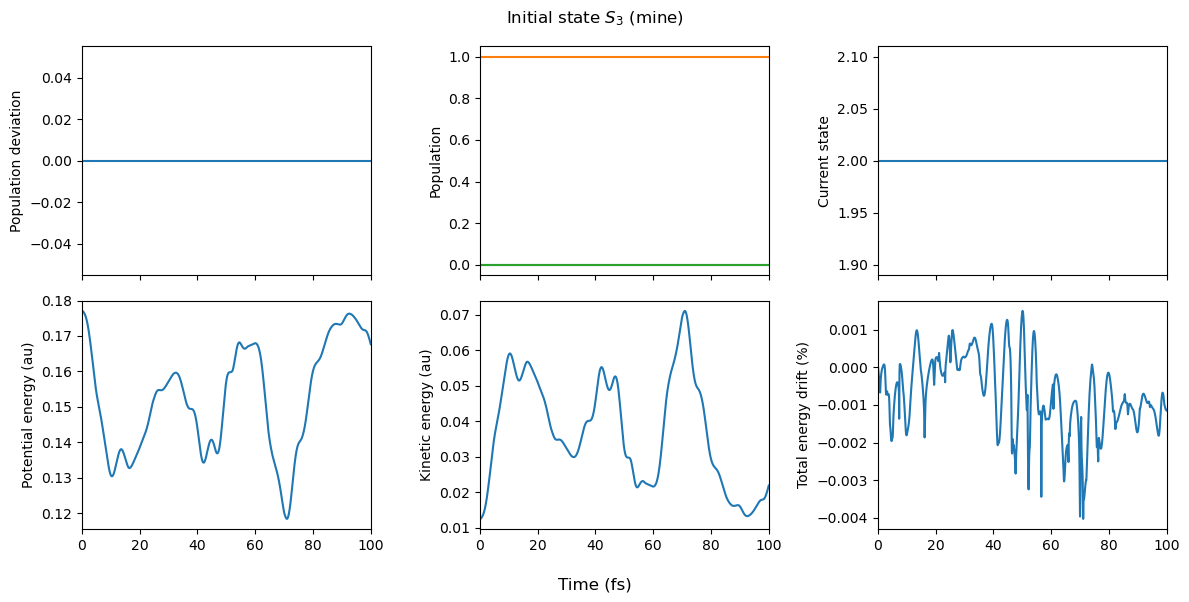

In [24]:
curr_coef = np.take_along_axis(
    np.array(coef_log), np.array(states_log).reshape(-1, 1) - sh.first_state, axis=1
)
pop = np.abs(coef_log) ** 2
time = np.array(range(len(coef_log))) * 0.1 + 0.1

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (fs)")
for _ in axs:
    _.set_xlim([0, time[-1]])
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, pop.sum(axis=1) - 1)
axs[1].set_ylabel("Population")
axs[1].plot(time, pop)
axs[2].set_ylabel("Current state")
axs[2].plot(time, states_log)
axs[3].set_ylabel("Potential energy (au)")
axs[3].plot(time, pot_log)
axs[4].set_ylabel("Kinetic energy (au)")
axs[4].plot(time, ekin_log)
axs[5].set_ylabel("Total energy drift (%)")
# axs[5].set_ylim([-0.0003, 0.0023])
axs[5].plot(time, (ener_log - ener_log[0]) / ener_log[0] * 100)
# axs[7].plot(time, ener_log)
# for a in axs:
#     a.axvline(time[73], c='r')
fig.suptitle("Initial state $S_3$ (mine)")

Text(0.5, 0.98, 'Initial state $S_3$ (scipy)')

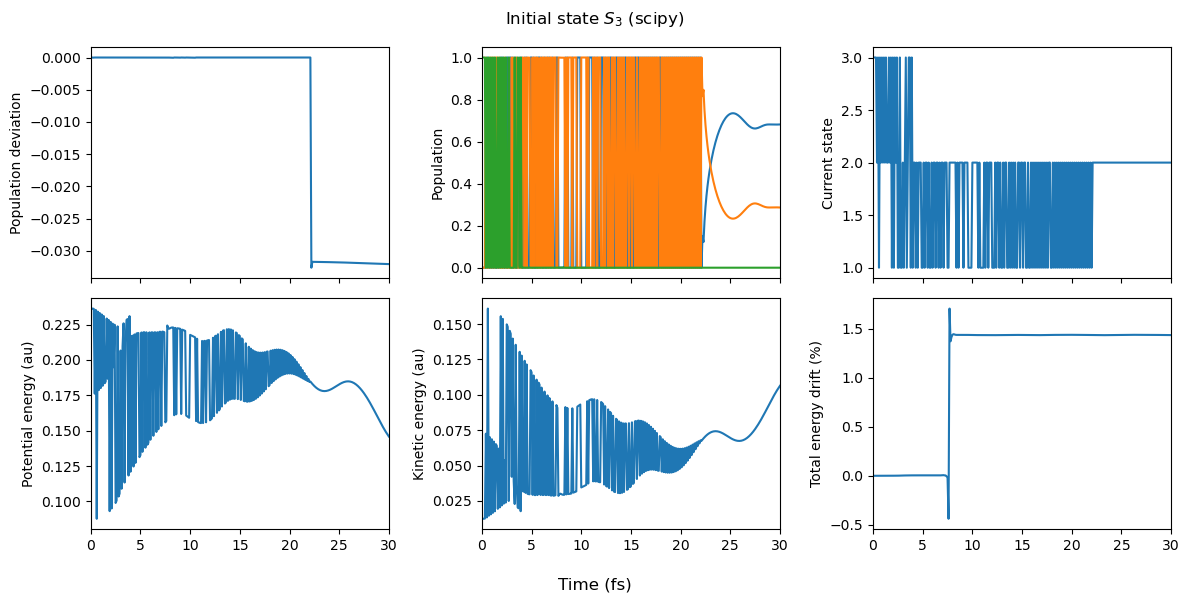

In [51]:
curr_coef = np.take_along_axis(
    np.array(coef_log), np.array(states_log).reshape(-1, 1) - sh.first_state, axis=1
)
pop = np.abs(coef_log) ** 2
time = np.array(range(len(coef_log))) * 0.1 + 0.1

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, tight_layout=True)
axs = ax.flatten()
fig.supxlabel("Time (fs)")
for _ in axs:
    _.set_xlim([0, time[-1]])
axs[0].set_ylabel("Population deviation")
axs[0].plot(time, pop.sum(axis=1) - 1)
axs[1].set_ylabel("Population")
axs[1].plot(time, pop)
axs[2].set_ylabel("Current state")
axs[2].plot(time, states_log)
axs[3].set_ylabel("Potential energy (au)")
axs[3].plot(time, pot_log)
axs[4].set_ylabel("Kinetic energy (au)")
axs[4].plot(time, ekin_log)
axs[5].set_ylabel("Total energy drift (%)")
# axs[5].set_ylim([-0.0003, 0.0023])
axs[5].plot(time, (ener_log - ener_log[0]) / ener_log[0] * 100)
# axs[7].plot(time, ener_log)
# for a in axs:
#     a.axvline(time[73], c='r')
fig.suptitle("Initial state $S_3$ (scipy)")

In [ ]:
pop_fixed = pop.copy()

In [84]:
pop_scipy = pop.copy()

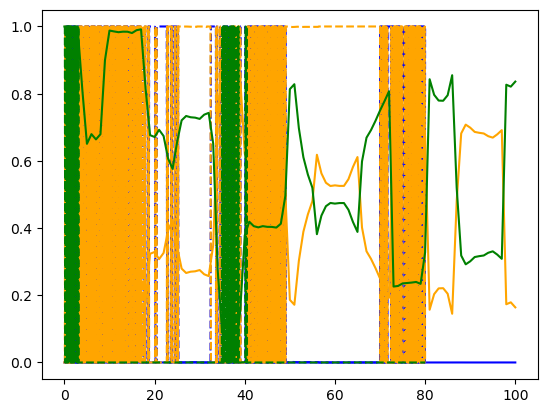

In [150]:
tmp = np.genfromtxt("/projects/ml4chem/xinyang/azomethane/ml/namd_s3/7520/coeff-n.out")[:, 1:-1]
colors = ["blue", "orange", "green", "red", "black"]
for i in range(3):
    plt.plot(tmp[:, 0], tmp[:, i + 1], c=colors[i])
    plt.plot(time, pop[:, i], ls="--", c=colors[i])

In [108]:
np.maximum(np.abs(np.random.random(3) + np.random.random(3) * 1j), (np.abs(np.random.random(3) + np.random.random(3) * 1j)))

array([0.9431558 , 1.345001  , 0.59451097])

## Quantum population

In [6]:
state = 1
nstates = 3
ml_dir = f"test_ml/results_namd_s{state}.new"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/namd_s{state}"

In [11]:
state = 2
nstates = 3
ml_dir = f"test_ml/results_namd_s{state}.vec"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/namd_s{state}"

In [9]:
state = 2
nstates = 3
ml_dir = f"test_ml/results_namd_lz_s{state}.vec"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/namd_s{state}"

In [16]:
state = 3
nstates = 4
ml_dir = f"test_ml/results_bomd_pl_s{state}"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd_pl_s{state}"

In [2]:
state = 3
nstates = 4
ml_dir = f"test_ml/results_namd_pl_s{state}"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/namd_pl_s{state}"

In [8]:
state = 3
ml_dir = f"test_ml/results_bomd_s{state}"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd_s{state}"

In [10]:
state = 3
ml_dir = f"test_ml/results_namd_without_hops_s{state}"
nexmd_dir = f"/projects/ml4chem/xinyang/azomethane/ml/bomd_with_coeff_s{state}"

In [2]:
colors = ["#2ecc71", "#2980b9", "#e74c3c", "#34495e", "#f1c40f", "#9b59b6"]
x_size, y_size = plt.rcParams.get("figure.figsize")

In [4]:
PLOT_INDIVIDUAL_TRAJECTORIES = False

/tmp/ipykernel_470440/2630240582.py:41: RuntimeWarning: invalid value encountered in divide
  pop_ml /= count.reshape(-1, 1)


(0.0, 1.0)

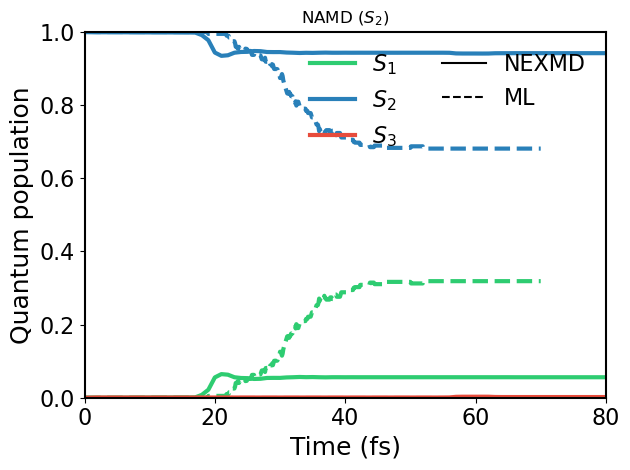

In [10]:
nsteps_ml = 1000
min_steps = nsteps_ml // 10 + 1
fig, ax = plt.subplots(1, 1, figsize=(x_size, y_size), tight_layout=True)
[x.set_linewidth(1.5) for x in ax.spines.values()]
# disable y ticks (arbitrary)
# ax.get_yaxis().set_ticks([])
# set x tick label size
ax.tick_params(labelsize=16)
# x, y labels
ax.set_xlabel("Time (fs)", fontsize=18)
ax.set_ylabel("Quantum population", fontsize=18)
ax.set_title(f"NAMD ($S_{state}$)")
time = np.arange(1, nsteps_ml + 1) * 0.1
e0 = []
pop_ml = np.zeros((nsteps_ml, nstates))
count = np.zeros(nsteps_ml)
dirs = os.listdir(ml_dir)
length = len(dirs)
dirs_filtered = []
# for i in dirs[:108]:
for i in range(200):
    i = str(i)
    dir = f"{ml_dir}/{i}"
    if not os.path.exists(f"{dir}/population.txt"):
        continue
    pop = np.genfromtxt(f"{dir}/population.txt")
    pop_sum = np.sum(pop, axis=1)
    if any(pop_sum > 1.01):
        print(dir)
        continue
    else:
        dirs_filtered.append(i)
    # dirs_filtered.append(i)
    total_steps = len(pop)
    if PLOT_INDIVIDUAL_TRAJECTORIES:
        for j in range(nstates):
            ax.plot(time[:len(pop)], pop[:, j], c=colors[j], ls="--", alpha=0.01)
    pop_ml[:total_steps] += pop
    e0.append(pop[0, 0])
    count[:total_steps] += 1
pop_ml /= count.reshape(-1, 1)
pop_nexmd = np.zeros((nsteps_ml // 10 + 1, nstates + 1))
count = np.zeros(nsteps_ml // 10 + 1)
dirs = np.genfromtxt(f"{nexmd_dir}/123", dtype=str)
for idx in dirs_filtered:
    i = dirs[int(idx)]
    dir = f"{nexmd_dir}/{i}"
    pop = np.genfromtxt(f"{dir}/coeff-n.out")[:, 1:-1]
    total_steps = len(pop)
    if PLOT_INDIVIDUAL_TRAJECTORIES:
        for i in range(nstates):
            ax.plot(pop[:, 0], pop[:, i + 1], c=colors[i], alpha=0.05)
    pop_nexmd[:total_steps] += pop
    if total_steps < min_steps:
        pop_nexmd[total_steps:] += pop[-1]
    count += 1
pop_nexmd /= count.reshape(-1, 1)
pop_nexmd[:, 0] = np.arange(0, min_steps)
for i in range(nstates):
    ax.plot(time, pop_ml[:, i], c=colors[i], ls="--", linewidth=3)
    ax.plot(pop_nexmd[:, 0], pop_nexmd[:, i + 1], c=colors[i], label=f"$S_{i + 1}$", linewidth=3)
ax.plot([], [], c="k", label="NEXMD")
ax.plot([], [], c="k", ls="--", label="ML")
ax.legend(fontsize=16, framealpha=0, loc="upper right", ncol=2)
ax.set_xlim([0, 80])
ax.set_ylim([0, 1])

In [13]:
pop_nexmd

array([[0.00000000e+00, 0.00000000e+00, 2.00000000e+02, 0.00000000e+00],
       [1.00000000e+00, 2.42301230e-03, 1.99940332e+02, 5.72445786e-02],
       [2.00000000e+00, 9.81290200e-04, 1.99868716e+02, 1.30302794e-01],
       [3.00000000e+00, 4.46015930e-03, 1.99869027e+02, 1.26512468e-01],
       [4.00000000e+00, 6.28555070e-03, 1.98880307e+02, 1.13407052e-01],
       [5.00000000e+00, 1.65102901e-02, 1.96872263e+02, 1.11226806e-01],
       [6.00000000e+00, 2.89699696e-02, 1.94860116e+02, 1.10914277e-01],
       [7.00000000e+00, 4.75892463e-02, 1.93839560e+02, 1.12851142e-01],
       [8.00000000e+00, 6.34632280e-02, 1.93823204e+02, 1.13332289e-01],
       [9.00000000e+00, 7.82330241e-02, 1.93810474e+02, 1.11293176e-01],
       [1.00000000e+01, 9.30498038e-02, 1.91796364e+02, 1.10586545e-01],
       [1.10000000e+01, 8.90568957e-02, 1.76804823e+02, 1.06119646e-01],
       [1.20000000e+01, 6.05502027e-02, 1.33840450e+02, 9.90000494e-02],
       [1.30000000e+01, 4.72574691e-02, 8.38753515e

Text(0.5, 0, 'Time (fs)')

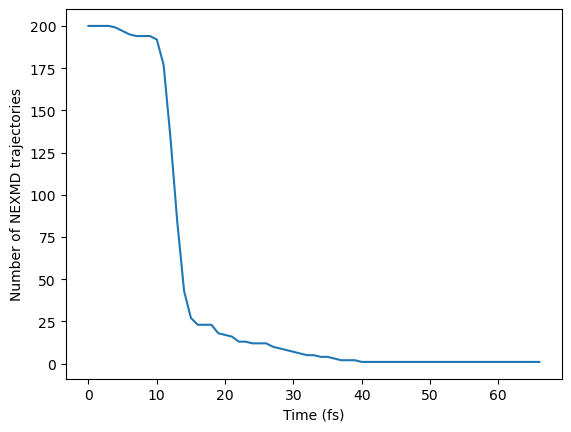

In [6]:
plt.plot(pop_nexmd[:, 0], count)
plt.ylabel("Number of NEXMD trajectories")
plt.xlabel("Time (fs)")

## Classical population

In [8]:
def onehot(states, nstates):
    one_hot_encoded = np.zeros((states.size, nstates), dtype=int)
    one_hot_encoded[np.arange(states.size), states.astype(int) - 1] = 1
    return one_hot_encoded

/tmp/ipykernel_1523588/2822949007.py:18: RuntimeWarning: invalid value encountered in divide
  pop_ml /= count.reshape(-1, 1)


Text(0.5, 1.0, 'NAMD ($S_3$)')

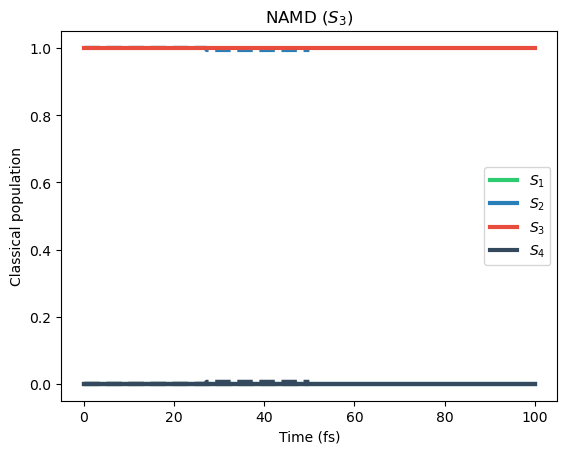

In [9]:
nstates = 4
nsteps_ml = 1000
fig, ax = plt.subplots()
time = np.arange(1, nsteps_ml + 1) * 0.1
e0 = []
pop_ml = np.zeros((nsteps_ml, nstates))
count = np.zeros(nsteps_ml)
for i in dirs_filtered:
    dir = f"{ml_dir}/{i}"
    states = np.genfromtxt(f"{dir}/states.txt")
    states = onehot(states, nstates)
    total_steps = len(states)
    if PLOT_INDIVIDUAL_TRAJECTORIES:
        for j in range(nstates):
            ax.plot(time[: len(states)], states[:, j], c=colors[j], ls="--", alpha=0.01)
    pop_ml[:total_steps] += states
    count[:total_steps] += 1
pop_ml /= count.reshape(-1, 1)
pop_nexmd = np.zeros((nsteps_ml // 10 + 1, nstates))
count = np.zeros(nsteps_ml // 10 + 1)
for idx in dirs_filtered:
    i = dirs[int(idx)]
    dir = f"{nexmd_dir}/{i}"
    tmp = np.genfromtxt(f"{dir}/coeff-n.out", usecols=(0, 1))
    states = onehot(tmp[:, 0], nstates)
    total_steps = len(states)
    if PLOT_INDIVIDUAL_TRAJECTORIES:
        for j in range(nstates):
            ax.plot(tmp[:, 1], states[:, j], c=colors[j], alpha=0.05)
    pop_nexmd[:total_steps] += states
    count[:total_steps] += 1
pop_nexmd /= count.reshape(-1, 1)
time_nexmd = np.arange(0, len(pop_nexmd)) 
for i in range(nstates):
    ax.plot(time, pop_ml[:, i], c=colors[i], ls="--", linewidth=3)
    ax.plot(time_nexmd, pop_nexmd[:, i], c=colors[i], linewidth=3, label=f"$S_{i + 1}$")
ax.legend()
ax.set_xlabel("Time (fs)")
ax.set_ylabel("Classical population")
ax.set_title(f"NAMD ($S_{state}$)")

/tmp/ipykernel_2855400/2841937665.py:30: RuntimeWarning: invalid value encountered in divide
  pes_ml /= count.reshape(-1, 1)
/tmp/ipykernel_2855400/2841937665.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=16, framealpha=0, loc="upper left", ncol=2)


(0.0, 11.1)

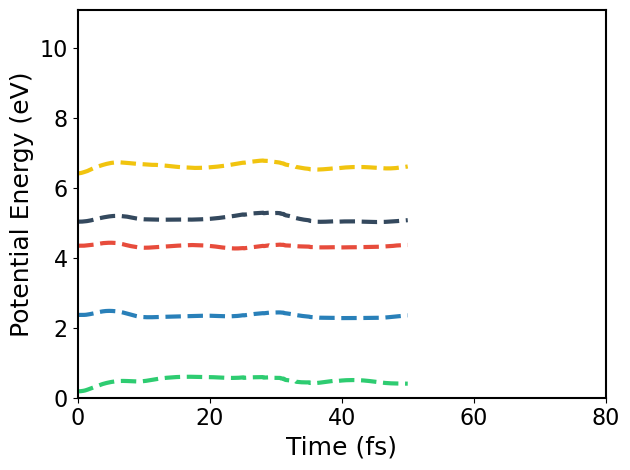

In [11]:
nstates = 5
nsteps_ml = 1000
fig, ax = plt.subplots(1, 1, figsize=(x_size, y_size), tight_layout=True)
[x.set_linewidth(1.5) for x in ax.spines.values()]
# disable y ticks (arbitrary)
# ax.get_yaxis().set_ticks([])
# set x tick label size
ax.tick_params(labelsize=16)
# x, y labels
ax.set_xlabel("Time (fs)", fontsize=18)
ax.set_ylabel("Potential Energy (eV)", fontsize=18)
# ax.set_title(f"NAMD ($S_{state}$)")
time = np.arange(1, nsteps_ml + 1) * 0.1
e0 = []
pes_ml = np.zeros((nsteps_ml, nstates))
count = np.zeros(nsteps_ml)
dirs = os.listdir(ml_dir)
length = len(dirs)
# for i in dirs:
for i in dirs_filtered:
    dir = f"{ml_dir}/{i}"
    pes = np.genfromtxt(f"{dir}/epot.txt") * au2eV
    total_steps = len(pes)
    if PLOT_INDIVIDUAL_TRAJECTORIES:
        for j in range(nstates):
            ax.plot(time[:len(pes)], pes[:, j], c=colors[j], ls="--", alpha=0.1)
    pes_ml[:total_steps] += pes
    e0.append(pes[0, 0])
    count[:total_steps] += 1
pes_ml /= count.reshape(-1, 1)
e0 = np.array(e0)
pes_nexmd = np.zeros((nsteps_ml // 10 + 1, nstates + 1))
count = np.zeros(nsteps_ml // 10 + 1)
dirs = np.genfromtxt(f"{nexmd_dir}/123", dtype=str)[:length]
# for dir in dirs:
# for j, idx in enumerate(dirs_filtered):
#     i = dirs[int(idx)]
#     dir = f"{nexmd_dir}/{i}"
#     pes = np.genfromtxt(f"{dir}/pes.out")
#     # pes = np.genfromtxt(f"{nexmd_dir}/{dir}/pes.out")
#     total_steps = len(pes)
#     # pes[:, 1:] *= eV2au
#     pes[:, 1:] -= pes[1, 1] - e0[j]
#     if PLOT_INDIVIDUAL_TRAJECTORIES:
#         for i in range(nstates):
#             ax.plot(pes[:, 0], pes[:, i + 1], c=colors[i], alpha=0.05)
#     pes_nexmd[:total_steps] += pes
#     count[:total_steps] += 1
# pes_nexmd /= count.reshape(-1, 1)
for i in range(nstates):
    ax.plot(time, pes_ml[:, i], c=colors[i], ls="--", linewidth=3)
    # ax.plot(pes_nexmd[:, 0], pes_nexmd[:, i + 1], c=colors[i], linewidth=3, label=f"$S_{i}$")
# ax.plot([], [], c="k", label="NEXMD")
# ax.plot([], [], c="k", ls="--", label="ML")
ax.legend(fontsize=16, framealpha=0, loc="upper left", ncol=2)
ax.set_xlim([0, 80])
ax.set_ylim([0, 11.1])

## PES

In [50]:
fig.savefig("namd_pes.svg", transparent=True)

In [20]:
0.5 /au2eV

0.018374654433845825

0 2.5818441406155883
1 0.055086508759297825
10 -0.06804487982325846
100 -0.14965687152153406
101 2.5070172951487852
102 1.3342937868963272
103 -0.0059744338804142245
104 -0.027625204476773958
105 1.1445801588593132
106 4.845964514170556
109 -0.14251329514565417
11 1.596526723410717
110 1.2360667312512976
112 8.43041534358914
113 2.3199705521362626
114 1.6986118464298947
115 1.3271065285899157
116 4.589708081673818
117 -0.5654063274095453
118 0.13856024227569388
12 -0.3840580520044207
120 -1.183937988733182
121 5.732425662414848
122 0.062287424695175744
124 -0.3221061797728796
125 0.44741526103949786
126 -0.5802646674139746
127 0.8978158589581453
129 0.19507669289310287
13 0.35687423779530447
130 0.40556474008893606
131 1.0018517247319176
132 9.39209192500613
133 3.1540705659650197
134 0.19672248774353254
135 0.5363181796443387
136 2.9955340376563977
138 -0.0152576984651605
139 1.8532591506592664
140 -0.10704732324712618
142 5.35314636193874
143 1.1597745779780488
145 3.6749929066420997

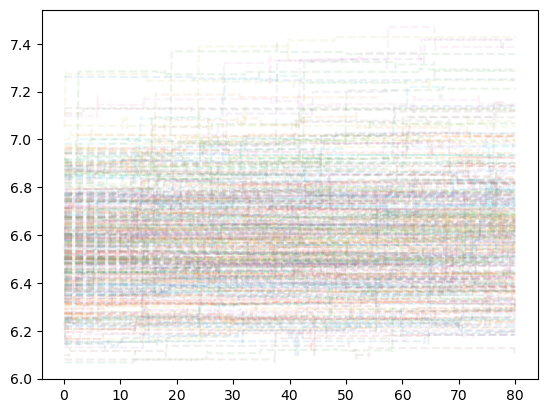

In [25]:
time = np.arange(1, nsteps_ml + 1) * 0.1
for i in dirs_filtered:
    dir = f"{ml_dir}/{i}"
    etot = np.genfromtxt(f"{dir}/etot.txt") * au2eV
    print(i, (etot[-1] - etot[0]) / etot[0] * 100)
    plt.plot(time[:len(etot)], etot, ls="--", alpha=0.1)

In [14]:
dirs_filtered

[]

In [4]:
import warnings

warnings.warn(
        "Make sure to modify the dataset path in QM7_ax_example.py before running "
        "this example. For this test (Ray parallelized optimization), you MUST provide "
        "an absolute path to the dataset."
    )

/tmp/ipykernel_220364/2787238602.py:3: UserWarning: Make sure to modify the dataset path in QM7_ax_example.py before running this example. For this test (Ax sequential optimization), a relative path can be used. The work directory for each trial will be ./test_ax/index. If the dataset is in ./dataset, the relative path should be ../../dataset. However, an absolute path is strongly recommended.
  warnings.warn(


In [8]:
warnings.warn(
    "\nMake sure to modify the dataset path in QM7_ax_example.py before running this example.\n"
    "For this test (Ax sequential optimization), a relative path can be used.\n"
    "The work directory for each trial will be ./test_ax/index.\n"
    "If the dataset is in ./dataset, the relative path should be ../../dataset.\n"
    "However, an absolute path is strongly recommended."
)

/tmp/ipykernel_220364/2136083439.py:1: UserWarning: 
Make sure to modify the dataset path in QM7_ax_example.py before running this example.
For this test (Ax sequential optimization), a relative path can be used.
The work directory for each trial will be ./test_ax/index.
If the dataset is in ./dataset, the relative path should be ../../dataset.
However, an absolute path is strongly recommended.
  warnings.warn(


In [2]:
from ase import Atoms
from ase.build import add_vacuum
import numpy as np

# Define the parameters for the MX2 structure
# Lattice constant in Ångstrom
a = 3.18
# Lattice constant for the z-axis (vacuum spacing)
c = 12.0

# Atomic species
# Transition metal
M = "Mo"  
# Chalcogen
X = "S" 

# Atomic positions in fractional coordinates
positions = [
    # M atom at the center
    (0.0, 0.0, 0.5),  
    # X atom above
    (1 / 3, 2 / 3, 0.6),  
    # X atom below
    (2 / 3, 1 / 3, 0.4),  
]

# Create the MX2 structure
# Hexagonal unit cell with vacuum
cell = [
    [a, 0, 0],
    [-a / 2, a * np.sqrt(3) / 2, 0],
    [0, 0, c],
]  

# Periodic boundary conditions in x and y only
atoms = Atoms(
    symbols=[M, X, X], scaled_positions=positions, cell=cell, pbc=[True, True, False]
) 

# Add vacuum to avoid interactions in z
add_vacuum(atoms, vacuum=10.0)
atoms = atoms.repeat((10, 10, 1))

# Save as CIF format
atoms.write("MX2_monolayer.cif") 

Atoms(symbols='Mo100S200', pbc=[True, True, False], cell=[[31.8, 0.0, 0.0], [-15.9, 27.53960784034515, 0.0], [0.0, 0.0, 22.0]])


In [36]:
import math
from typing import List, TextIO

import numpy as np


def lattice_vector(lengths: List, angles: List):
    lengths = map(float, lengths)
    a, b, c = lengths
    angles = map(lambda s: float(s) / 180 * math.pi, angles)
    alpha, beta, gamma = angles
    va = [a, 0, 0]
    vb = [b * math.cos(gamma), b * math.sin(gamma), 0]
    tmp = (math.cos(alpha) - math.cos(beta) * math.cos(gamma)) / math.sin(gamma)
    vc = [
        c * math.cos(beta),
        c * tmp,
        c * math.sqrt(math.sin(beta) ** 2 - tmp**2),
    ]
    return va, vb, vc


def read_fractions(cif: TextIO):
    fractions = []
    while True:
        line = cif.readline()
        if not line:
            return fractions
        fractions.append(line.split()[3:6])


with open("MX2_monolayer.cif", "r") as cif:
    while True:
        line = cif.readline()
        if line.startswith("_cell_length_a"):
            lengths = [line.split()[1]]
            for i in range(2):
                lengths.append(cif.readline().split()[1])
            angles = []
            for i in range(3):
                angles.append(cif.readline().split()[1])
        if line.startswith("  _atom_site_occupancy"):
            fractions_str = read_fractions(cif)
            break

lattice_matrix = np.stack(lattice_vector(lengths, angles))
fractions = np.array(fractions_str, dtype=float).T
coordinates = np.matmul(lattice_matrix, fractions).T

In [54]:
tmp = np.argsort(coordinates[:, -1])

In [56]:
coordinates

array([[ 0.00000000e+00,  0.00000000e+00,  6.00000000e+00],
       [ 1.06000000e+00,  1.30597386e+00,  7.20000000e+00],
       [ 2.12000000e+00, -1.42013072e-01,  4.80000000e+00],
       [ 0.00000000e+00,  2.75396078e+00,  6.00000000e+00],
       [ 1.06000000e+00,  4.05993464e+00,  7.20000000e+00],
       [ 2.12000000e+00,  2.61194771e+00,  4.80000000e+00],
       [ 0.00000000e+00,  5.50792157e+00,  6.00000000e+00],
       [ 1.06000000e+00,  6.81389542e+00,  7.20000000e+00],
       [ 2.12000000e+00,  5.36590850e+00,  4.80000000e+00],
       [ 0.00000000e+00,  8.26188235e+00,  6.00000000e+00],
       [ 1.06000000e+00,  9.56785621e+00,  7.20000000e+00],
       [ 2.12000000e+00,  8.11986928e+00,  4.80000000e+00],
       [ 0.00000000e+00,  1.10158431e+01,  6.00000000e+00],
       [ 1.06000000e+00,  1.23218170e+01,  7.20000000e+00],
       [ 2.12000000e+00,  1.08738301e+01,  4.80000000e+00],
       [ 0.00000000e+00,  1.37698039e+01,  6.00000000e+00],
       [ 1.06000000e+00,  1.50757778e+01

In [55]:
coordinates = coordinates[idx]

array([[ 1.16600000e+01,  5.95908496e-01,  4.80000000e+00],
       [ 8.48000000e+00, -3.32201307e+00,  4.80000000e+00],
       [ 8.48000000e+00,  2.18590850e+00,  4.80000000e+00],
       [ 2.12000000e+01, -9.68201307e+00,  4.80000000e+00],
       [ 1.80200000e+01, -8.09201307e+00,  4.80000000e+00],
       [ 5.30000000e+00,  6.52986928e+00,  4.80000000e+00],
       [ 5.30000000e+00,  3.77590850e+00,  4.80000000e+00],
       [ 5.30000000e+00,  1.02194771e+00,  4.80000000e+00],
       [ 1.48400000e+01, -3.74805229e+00,  4.80000000e+00],
       [ 1.48400000e+01, -6.50201307e+00,  4.80000000e+00],
       [ 2.12000000e+00,  8.11986928e+00,  4.80000000e+00],
       [ 5.30000000e+00, -1.73201307e+00,  4.80000000e+00],
       [ 8.48000000e+00, -5.68052288e-01,  4.80000000e+00],
       [ 2.12000000e+00,  2.61194771e+00,  4.80000000e+00],
       [ 1.16600000e+01, -4.91201307e+00,  4.80000000e+00],
       [ 2.12000000e+00, -1.42013072e-01,  4.80000000e+00],
       [ 1.16600000e+01, -2.15805229e+00